In [2]:
%load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from captum.attr import (
    DeepLift,
    DeepLiftShap,
    GradientShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
from PIL import Image
from torchvision import datasets, models, transforms
from torchvision.models.vgg import VGG11_Weights

from data import PascalVOC2007
from utils import cut_model_from_layer, cut_model_to_layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
model.to(device)
model.classifier[-1] = nn.Linear(4096, 20)
# Load the pretrained model
model.load_state_dict(torch.load('VGG11_PascalVOC.pt', map_location=device))
model.eval()

preprocess = transforms.Compose([
    # transforms.Resize(256),                # Resize the image to 256 on the shortest side
    # transforms.CenterCrop(224),            # Crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                 # Convert to Tensor
    transforms.Normalize(                  # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
    
torch.manual_seed(123)
np.random.seed(123)

In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [4]:
test_data = PascalVOC2007("test", transform=preprocess)
train_data = PascalVOC2007("trainval", transform=preprocess)

Using downloaded and verified file: data\VOCtest_06-Nov-2007.tar
Extracting data\VOCtest_06-Nov-2007.tar to data
Using downloaded and verified file: data\VOCtrainval_06-Nov-2007.tar
Extracting data\VOCtrainval_06-Nov-2007.tar to data


In [5]:
import torch.utils
from torch.utils.data import DataLoader, Subset

BATCH_SIZE_TEST = 2
NUM_TEST = 8

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 32
# Take 3 random element not the first 3
dl_test = DataLoader(Subset(test_data, torch.randperm(len(test_data))[:NUM_TEST]), batch_size=BATCH_SIZE_TEST, shuffle=True)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=True)

In [5]:
for images, labels in dl_test:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([2, 3, 224, 224])
torch.Size([2, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 224, 224])


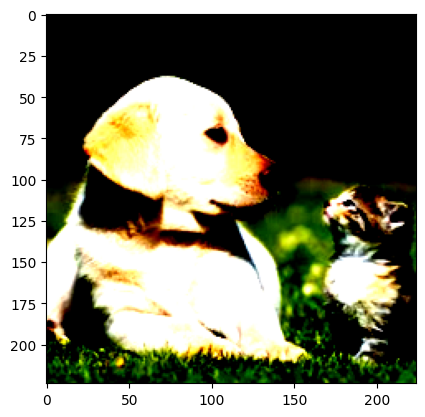

In [3]:
image = Image.open("test_image5.jpg")    
input_tensor = preprocess(image).unsqueeze(0)
print(input_tensor.shape)   
plt.imshow(input_tensor.squeeze(0).permute(1,2,0))

In [4]:
output = model(input_tensor.to(device))
output.shape

torch.Size([1, 1000])

In [5]:
# Print top k argmax
output.topk(5)

torch.return_types.topk(
values=tensor([[10.2349,  9.5935,  7.2709,  6.9979,  6.9787]],
       grad_fn=<TopkBackward0>),
indices=tensor([[207, 208, 222, 264, 162]]))

In [6]:
baseline_images = ["test_image1.jpg","test_image2.jpg", "test_image3.jpg"]
baseline_tensors = torch.stack([preprocess(Image.open(img)) for img in baseline_images])
baseline_dist = baseline_tensors
print(baseline_tensors.shape)

torch.Size([3, 3, 224, 224])


In [7]:
# baseline_dist = torch.randn(1, 3, 224, 224) * 0.001
baseline_dist = baseline_tensors
dl = DeepLiftShap(model)
attributions, delta = dl.attribute(input_tensor, baseline_dist, target=207, return_convergence_delta=True)
print('DeepLift Attributions:', attributions.shape)
print('Convergence Delta:', delta)

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


DeepLift Attributions: torch.Size([1, 3, 224, 224])
Convergence Delta: tensor([ 3.2197, -9.7148,  8.6854])


In [8]:
# attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())
attributions = attributions.mean(dim=1, keepdim=False)
attributions.shape

torch.Size([1, 224, 224])

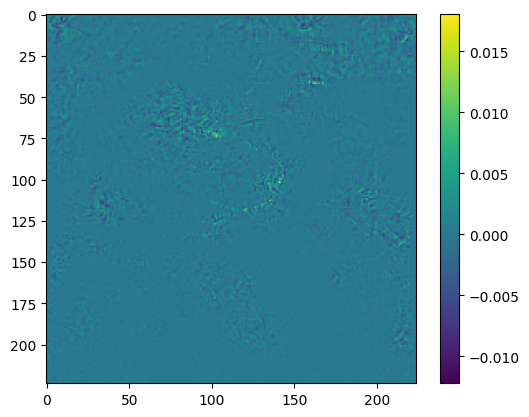

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(attributions[0].detach().numpy())
plt.colorbar()

In [10]:
model1 = cut_model_to_layer(model, "features.3", included=True)
model2 = cut_model_from_layer(model, "features.3", included=False)

input_to_model_1 = input_tensor
input_to_model_2 = model1(input_tensor)

In [11]:
input_to_model_2.shape

torch.Size([1, 128, 112, 112])

In [12]:
# dl = DeepLift(model2)
# baseline_dist = torch.randn_like(input_to_model_2) * 0.001
# attributions, delta = dl.attribute(input_to_model_2, baseline_dist, target=207, return_convergence_delta=True)
# print('DeepLift Attributions:', attributions)
# print('Convergence Delta:', delta)

In [13]:
# attributions = (attributions / (attributions.max() - attributions.min())
attributions = attributions.mean(dim=1, keepdim=False)
attributions.shape

torch.Size([1, 224])

TypeError: Invalid shape (224,) for image data

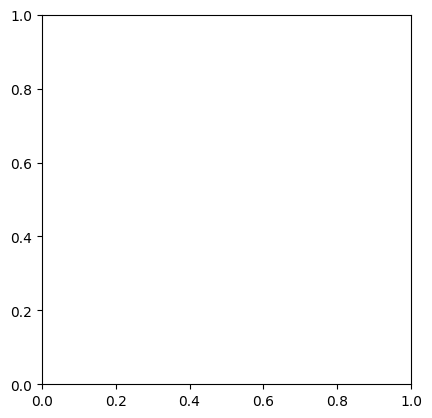

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(attributions[0].detach().numpy())
plt.colorbar()

In [ ]:
def calculate_attribution(model, input_tensor, layer, target=207, baseline_dist: torch.Tensor=None):
    model_to = cut_model_to_layer(model, layer, included=True) # Model from the start up to the layer
    model_from = cut_model_from_layer(model, layer, included=False) # Model from the layer to the end
    
    input_to_model = model_to(input_tensor)
    dl = DeepLiftShap(model_from)
    if baseline_dist is None:
        baseline_dist = torch.randn_like(input_to_model) * 0.001
    else:
        baseline_dist = model_to(baseline_dist)
        
    attributions, delta = dl.attribute(input_to_model, baseline_dist, target=target, return_convergence_delta=True)
    return attributions, delta

def plot_attributions(attributions, title="", show=True):
    # Average the attributions across the color channels to get a single channel attribution
    # attributions = attributions.sum(dim=1, keepdim=False)
    plt.imshow(attributions[0].detach().numpy())
    plt.title(title)
    plt.colorbar()
    if show:
        plt.show()

The sum of all the attributions is equal to the difference between the output of the model on the current input, minus the average output of the model on the baseline distribution.

------------------------------------------------------------------------------
        Layer (type)    map size      start       jump receptive_field 
        0             [224, 224]        0.5        1.0             1.0 
        1             [224, 224]        0.5        1.0             3.0 
        2             [224, 224]        0.5        1.0             3.0 
        3             [112, 112]        1.0        2.0             4.0 
        4             [112, 112]        1.0        2.0             8.0 
        5             [112, 112]        1.0        2.0             8.0 
        6               [56, 56]        2.0        4.0            10.0 
        7               [56, 56]        2.0        4.0            18.0 
        8               [56, 56]        2.0        4.0            18.0 
        9               [56, 56]        2.0        4.0            26.0 
        10              [56, 56]        2.0        4.0            26.0 
        11              [28, 28]        4.0        8.0   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1253.7097, grad_fn=<SumBackward0>)
tensor([ 3.5628, -7.7149,  8.1715])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1571.9705, grad_fn=<SumBackward0>)
tensor([ 3.5628, -7.7149,  8.1715])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(62.7365, grad_fn=<SumBackward0>)
tensor([ 3.1313, -1.9438,  4.6986])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(15.3892, grad_fn=<SumBackward0>)
tensor([ 1.4901e-06,  0.0000e+00, -9.5367e-07])


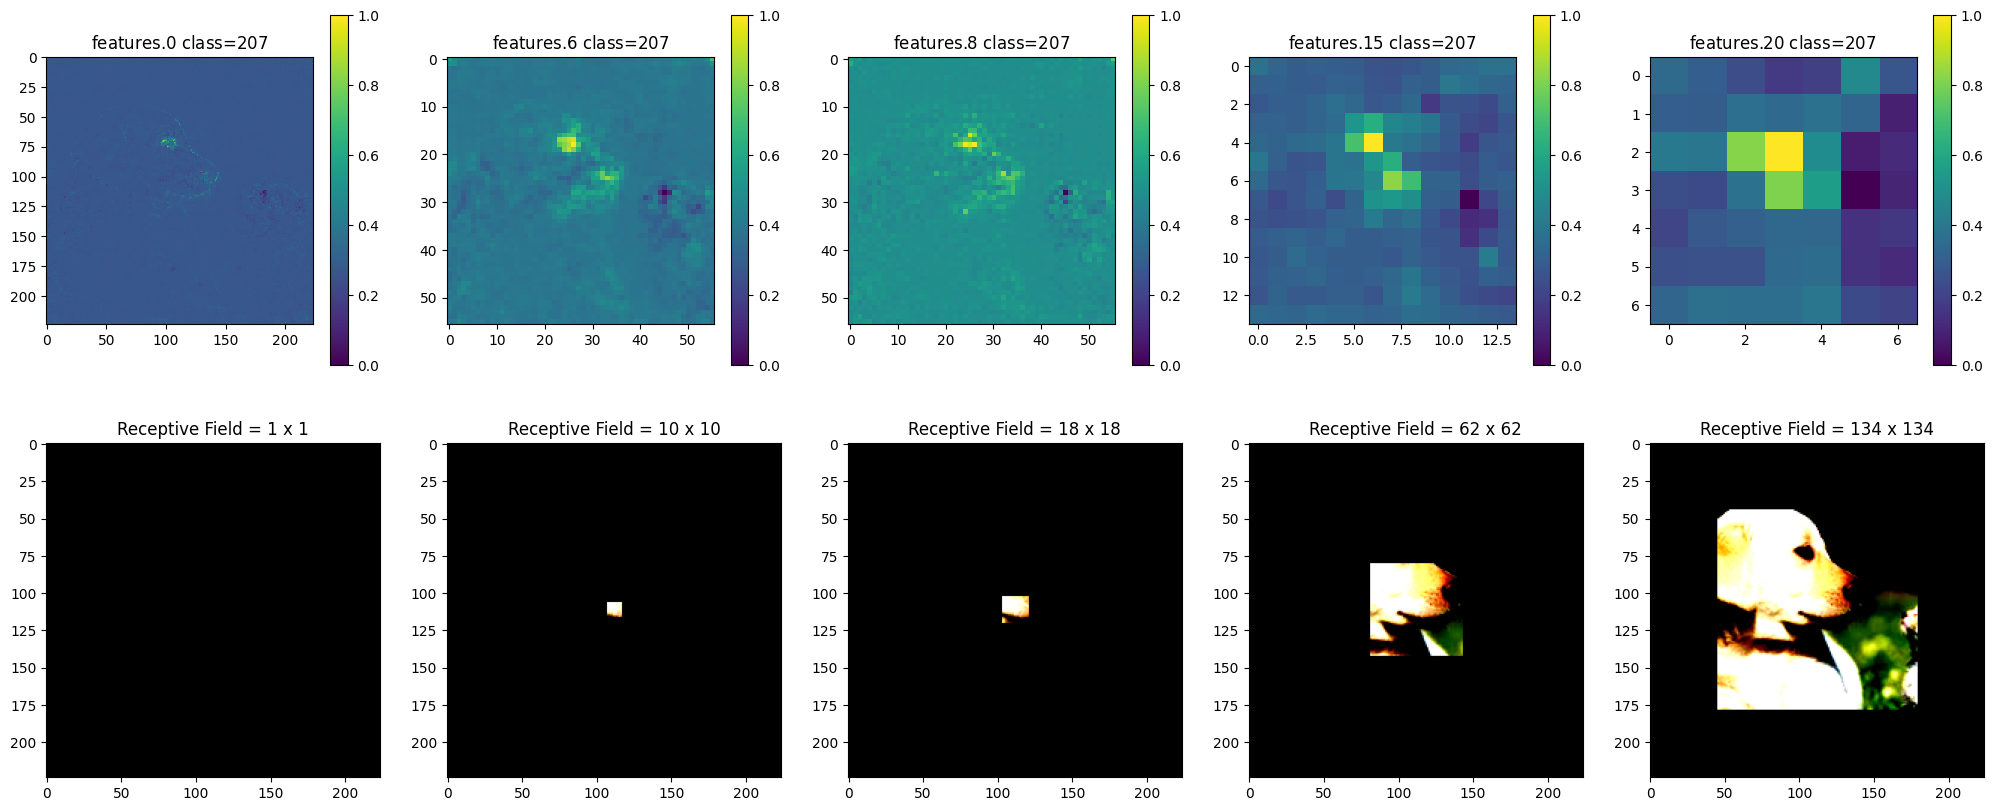

In [62]:
from torch_receptive_field import receptive_field

receptive_field_dict = receptive_field(cut_model_to_layer(model, "classifier.0", included=False), input_size=(3, 224, 224))

target = 207
layers = ["features.0","features.6", "features.8", "features.15", "features.20"]
plt.figure(figsize=(len(layers) * 5, 10))
# fix layout
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
for index, layer in enumerate(layers):
    # plt.subplot(2, len(layers)//2 + 1,index+1)
    plt.subplot(2, len(layers), index+1)
    attributions, delta = calculate_attribution(model,
                                                input_tensor,
                                                layer,
                                                target=target,
                                                baseline_dist=baseline_dist)
    attributions = attributions.sum(dim=1, keepdim=False)
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

    plot_attributions(attributions, f"{layer} class=${target}$", show=False)
    print(attributions.sum())
    # Normalize the attributions between 0 and 1
    print(delta)
    
    plt.subplot(2, len(layers), index+1 + len(layers))
    # Plot the receptive field
    rf = receptive_field_dict[layer.split(".")[1]]
    rf_size = int(rf["r"])
    # Crop the image at the center with a rf_size x rf_size
    black_background = torch.zeros_like(input_tensor)
    image_center = input_tensor.shape[-1] // 2
    left = image_center - rf_size // 2
    right = image_center + rf_size // 2
    black_background[:,:,left:right,left:right] = input_tensor[:,:,left:right,left:right]
    plt.imshow(black_background.squeeze(0).permute(1,2,0).detach().numpy())
    plt.title(f"Receptive Field = {rf_size} x {rf_size}")    

In [71]:
# Cut the model before the adaptive average pooling layer
model1 = cut_model_to_layer(model, "classifier.0", included=False)
model2 = cut_model_from_layer(model, "classifier.0", included=True)

print(model1)
d = receptive_field(model1, input_size=(3,224, 224))
d

Sequential(
  (features_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_1): ReLU(inplace=True)
  (features_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_4): ReLU(inplace=True)
  (features_5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_7): ReLU(inplace=True)
  (features_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_9): ReLU(inplace=True)
  (features_10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (features_11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_12): ReLU(inplace=True)
  (features_13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features_14): ReLU(inplace=True)


OrderedDict([('0',
              OrderedDict([('j', 1.0),
                           ('r', 1.0),
                           ('start', 0.5),
                           ('conv_stage', True),
                           ('output_shape', [-1, 3, 224, 224])])),
             ('1',
              OrderedDict([('j', 1.0),
                           ('r', 3.0),
                           ('start', 0.5),
                           ('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 224, 224])])),
             ('2',
              OrderedDict([('j', 1.0),
                           ('r', 3.0),
                           ('start', 0.5),
                           ('input_shape', [-1, 64, 224, 224]),
                           ('output_shape', [-1, 64, 224, 224])])),
             ('3',
              OrderedDict([('j', 2.0),
                           ('r', 4.0),
                           ('start', 1.0),
                           ('input_shape', [-1, 64, 224, 224]

In [ ]:
from typing import List

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from attributions import GradCAMPlusPlusNoResize


for images, labels in dl_test:
    print(images.shape)
    print(labels.shape)
    target_layer = model.features[-1]
    
    cam = GradCAMPlusPlusNoResize(model=model, target_layers=[target_layer])
    # cam = GradCAMPlusPlus(model=model, target_layers=[target_layer])

    targets = [ClassifierOutputTarget(labels[0])]

    grayscale_cam = cam(input_tensor=images[0:1], targets=targets, aug_smooth=True)
    # res = cam.get_cam_image(input_tensor, targets)
    break

torch.Size([2, 3, 224, 224])
torch.Size([2, 1])


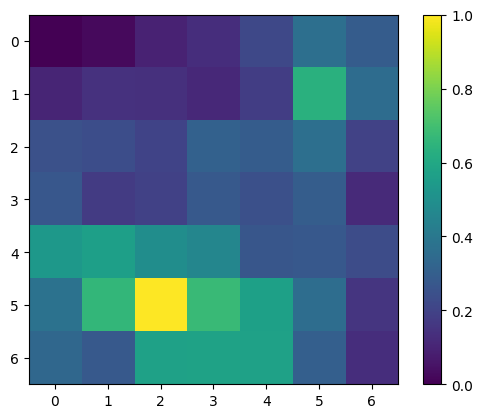

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15.594799


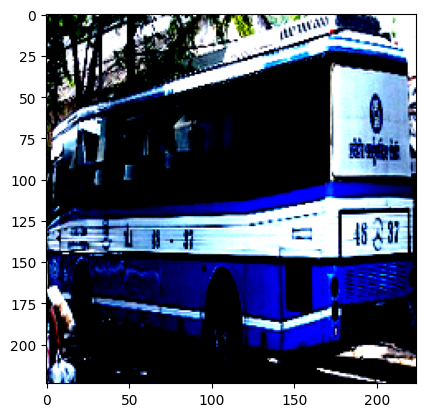

In [33]:
plt.imshow(grayscale_cam[0])
plt.colorbar()
plt.show()
plt.imshow(images[0].permute(1,2,0).detach().numpy())
print(grayscale_cam.sum())

In [29]:
from typing import Callable, List

from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing_extensions import Literal

from metrics import average_drop, increase_in_confidence, insertion_curve_AUC, deletion_curve_AUC
from utils import get_layer_name, scale_saliencies
from attributions import AttributionMethod, _DeepLiftShap, _GradCAMPlusPlus

from results import ResultMetrics
    
def calculate_metrics(model:nn.Module,
                    attribute_method: AttributionMethod,
                    test_dl: DataLoader,
                    train_dl: DataLoader,
                    layers: List[nn.Module],
                    result_metrics:ResultMetrics,
                    upsample:Literal['nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'] = "nearest",
                    rescale_saliency:bool = False,
                    rescale_perc:float = 0.3,
                    model_name:str = None) -> dict:
    """Function to calculate all the different metrics on the model using the given attribution method

    Args:
        model (nn.Module): The model to calculate the metrics on
        attribute_method (AttributionMethod): The attribution method to use
        test_dl (DataLoader): The dataloader to use for the test set
        train_dl (DataLoader): The dataloader to use for the train set (used only for the baseline distribution)
        layers (List[nn.Module]): The layers to calculate the metrics on
        upsample (Literal[&#39;nearest&#39;, &#39;linear&#39;, &#39;bilinear&#39;, &#39;bicubic&#39;, &#39;trilinear&#39;], optional): Upsampling method to upsample the saliency map. Defaults to "nearest".
        rescale_saliency (bool, optional): If set to true, rescale the saliency map to have a fixed are underneath it. Defaults to False.
        rescale_perc (float, optional): Parameter used to rescale the saliency map. Defaults to 0.3.

    Returns:
        dict: Dictionary containing the results of the metrics for each layer
    """
    if model_name is None:
        model_name = model.__class__.__name__
    layer_names = {layer: get_layer_name(model, layer) for layer in layers}
    
    res = {layer_names[layer]: 
            {"avg_drop":[],
             "increase": [],
             "insertion_curve_AUC": [],
             "deletion_curve_AUC": []}
            for layer in layers}
    
    for layer in layers:
        for images, labels in tqdm(test_dl):
            labels = labels.to(device).reshape(-1)
            images = images.to(device)
            
            # Use the train_dl as baseline distribution
            baseline_dist = torch.cat([images for images, _ in train_dl])
            
            attributions = attribute_method.attribute(model,
                                                    input_tensor=images,
                                                    layer=layer,
                                                    target=labels,
                                                    baseline_dist=baseline_dist)
            
            up = nn.Upsample(size=images.shape[2:], mode=upsample)
            saliency_maps = up(attributions)
            saliency_maps = (saliency_maps - saliency_maps.amin(dim=(2,3), keepdim=True)) / (saliency_maps.amax(dim=(2,3), keepdim=True) - saliency_maps.amin(dim=(2,3), keepdim=True))
            
            if rescale_saliency:
                saliency_maps = scale_saliencies(saliency_maps, perc=rescale_perc)
            
            avg_drop = average_drop(model, images, saliency_maps, labels)
            increase = increase_in_confidence(model, images, saliency_maps, labels)
            insertion_curve_AUC_score = insertion_curve_AUC(model, images, saliency_maps, labels)
            deletion_curve_AUC_score = deletion_curve_AUC(model, images, saliency_maps, labels)
            
            res[layer_names[layer]]["avg_drop"].append(avg_drop)
            res[layer_names[layer]]["increase"].append(increase)
            res[layer_names[layer]]["insertion_curve_AUC"].append(insertion_curve_AUC_score)
            res[layer_names[layer]]["deletion_curve_AUC"].append(deletion_curve_AUC_score)

        # For each layer, average the results
        res[layer_names[layer]]["avg_drop"] = torch.mean(torch.stack(res[layer_names[layer]]["avg_drop"])).item()
        res[layer_names[layer]]["increase"] = torch.mean(torch.stack(res[layer_names[layer]]["increase"])).item()
        res[layer_names[layer]]["insertion_curve_AUC"] = torch.mean(torch.stack(res[layer_names[layer]]["insertion_curve_AUC"])).item()
        res[layer_names[layer]]["deletion_curve_AUC"] = torch.mean(torch.stack(res[layer_names[layer]]["deletion_curve_AUC"])).item()
        
        result_metrics.add_results_all_layers(model_name, attribute_method.__class__.__name__, res)
    
    # # Average all the results
    # for layer in layers:
    #     for key in res[layer_names[layer]]:
    #         res[layer_names[layer]][key] = torch.mean(torch.stack(res[layer_names[layer]][key])).item()
    return res
            

In [31]:
results = ResultMetrics("results.json")
res = calculate_metrics(model,
                        _DeepLiftShap(),
                        dl_test,
                        dl_train,
                        layers=[model.features[6], model.features[16]],
                        result_metrics=results,
                        # ["features.6", "features.16"],
                        upsample="bilinear",
                        rescale_saliency=False,
                        )

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
results.results["VGG"]

{'features.6': {'avg_drop': 9.826704978942871,
  'increase': 25.0,
  'insertion_curve_AUC': 0.8033646941184998,
  'deletion_curve_AUC': 0.33377328515052795},
 'features.16': {'avg_drop': 1.4009959697723389,
  'increase': 25.0,
  'insertion_curve_AUC': 0.9179062247276306,
  'deletion_curve_AUC': 0.3770475685596466},
 '_GradCAMPlusPlus': {...}}

In [21]:
model._get_name()

'VGG'

In [19]:
res

{'features.6': {'avg_drop': 9.826704978942871,
  'increase': 25.0,
  'insertion_curve_AUC': 0.8033646941184998,
  'deletion_curve_AUC': 0.33377331495285034},
 'features.16': {'avg_drop': 1.4009959697723389,
  'increase': 25.0,
  'insertion_curve_AUC': 0.9179061651229858,
  'deletion_curve_AUC': 0.377047598361969}}

In [15]:
for layer in res:
    print(f"Layer = {layer}")
    print(f"Average Drop = {torch.mean(torch.stack(res[layer]['avg_drop']))}")
    print(f"Increase = {torch.mean(torch.stack(res[layer]['increase']))}")
    print(f"Deletion Curve AUC = {torch.mean(torch.stack(res[layer]['deletion_curve_AUC']))}")
    print(f"Insertion Curve AUC = {torch.mean(torch.stack(res[layer]['insertion_curve_AUC']))}")
    print()

Layer = features.6
Average Drop = 87.19320678710938
Increase = 0.0
Deletion Curve AUC = 0.33377328515052795
Insertion Curve AUC = 0.803364634513855

Layer = features.16
Average Drop = 35.256622314453125
Increase = 12.5
Deletion Curve AUC = 0.3770475387573242
Insertion Curve AUC = 0.9179062247276306

